# QRS detection

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import wfdb
import socket

# hard-code some colors
col = np.asarray([[228,26,28],
[55,126,184],
[77,175,74],
[152,78,163],
[255,127,0],
[255,255,51],
[166,86,40],
[247,129,191]])/256.0

# determine the paths for data/annotations based off the computer name
hostname=socket.gethostname()

if hostname=='alistair-pc70':
    data_path = '/data/challenge-2015/data/'
    ann_path = '/data/challenge-2015/ann/'
else:
    data_path = 'sample_data/challenge_training_data/'
    ann_path = 'sample_data/challenge_training_ann/'
    
    
%matplotlib inline

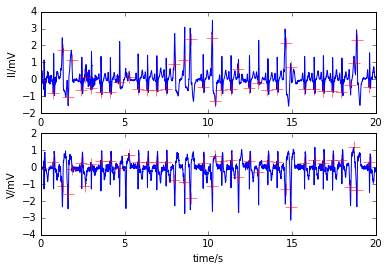

In [2]:
start = 0
end = 5000
end_time = 10
fs = 250
sample_name = 'v532s'
sig, fields = wfdb.rdsamp(data_path +  sample_name)
sample_annotation = wfdb.rdann(ann_path + sample_name, 'gqrs', sampfrom = start, sampto = end)

wfdb.plotwfdb(sig[start:end,:2], fields, annsamp=sample_annotation[0], annch = [0,1])

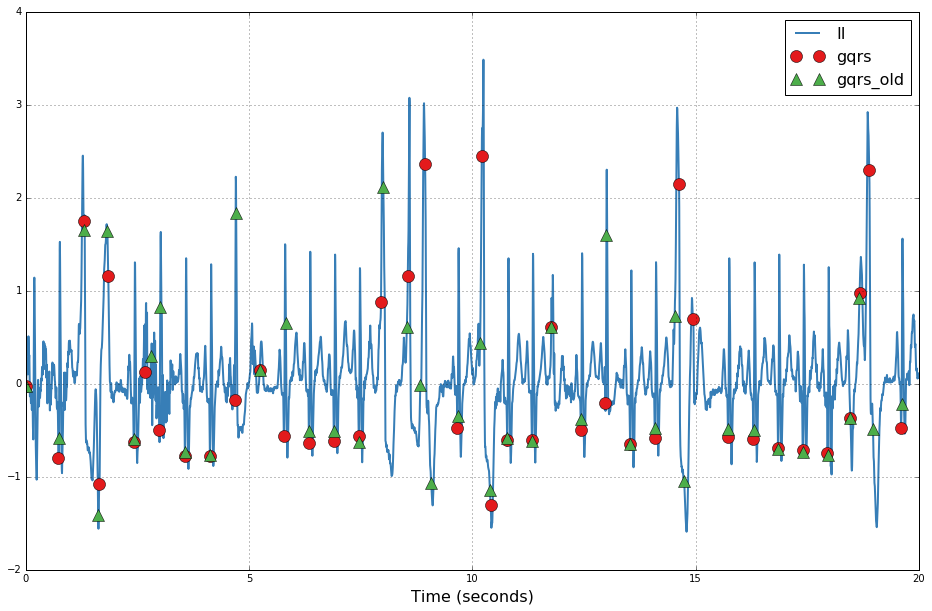

In [5]:
start = 0
end = 5000
end_time = 10
fs = 250
sample_name = 'v532s'
sig, fields = wfdb.rdsamp(data_path + sample_name)
sample_annotation = wfdb.rdann(ann_path + sample_name, 'gqrs', sampfrom = start, sampto = end)
gqrs_old = wfdb.rdann(ann_path + sample_name, 'gqrs_old', sampfrom = start, sampto = end)

# choose the lead to plot (annotations are generated off the first lead)
channel = 0

# create a time vector
t = np.linspace(float(start)/fs,float(end)/fs,end-start)


# plot the time series
plt.figure(figsize=[16,10])
plt.plot(t, sig[start:end,channel], '-',
         color=col[1],linewidth=2,
         label=fields['signame'][channel])

# plot the sample annotation
plt.plot(t[sample_annotation[0]], sig[sample_annotation[0],channel],
         color=col[0],
         linestyle='none',linewidth=3,
         marker='o',markersize=12,
         label='gqrs')

# plot the old gqrs
plt.plot(t[gqrs_old[0]], sig[gqrs_old[0],channel],
         color=col[2],
         linestyle='none',linewidth=3,
         marker='^',markersize=12,
         label='gqrs_old')

plt.xlabel('Time (seconds)',fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.show()

/usr/local/lib/python2.7/dist-packages/wfdb/_rdann.py:209: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  AT = filebytes[bpi, 1] >> 2  # anntype
/usr/local/lib/python2.7/dist-packages/wfdb/_rdann.py:53: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ts = ts + filebytes[bpi, 0] + 256 * (filebytes[bpi, 1] & 3)
/usr/local/lib/python2.7/dist-packages/wfdb/_rdann.py:216: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  AT = filebytes[bpi, 1] >> 2
/usr/local/lib/python2.7/dist-packages/wfdb/_rdann.py:78: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  auxlen = filebytes[bpi, 0]
/usr/local/lib/python2.7/dist-packages/wfdb/_rdann.py:79: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in

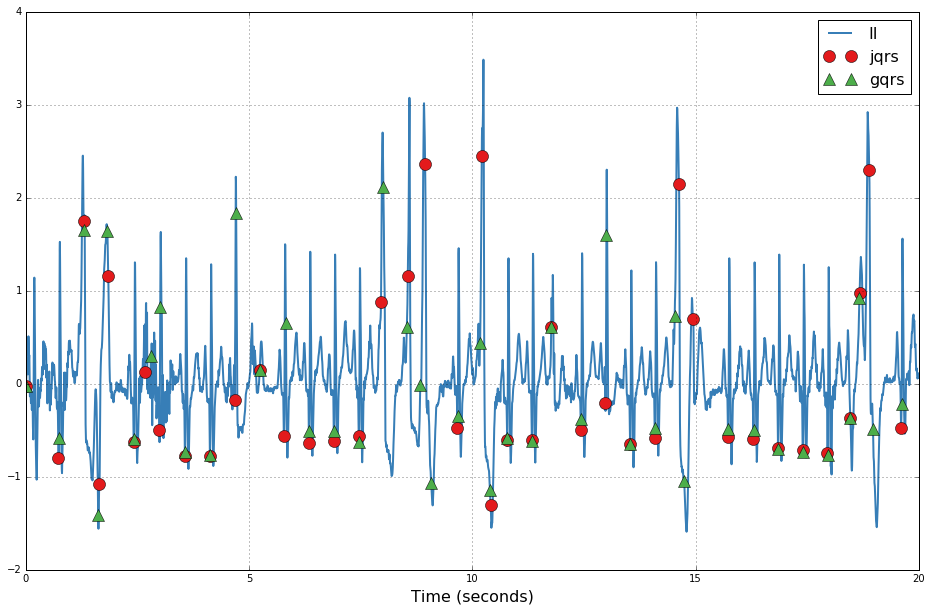

In [6]:
start = 0
end = 5000
end_time = 10
fs = 250
sample_name = 'v532s'
sig, fields = wfdb.rdsamp(data_path + sample_name)
jqrs = wfdb.rdann(ann_path + sample_name, 'jqrs', sampfrom = start, sampto = end)
gqrs = wfdb.rdann(ann_path + sample_name, 'gqrs', sampfrom = start, sampto = end)

# choose the lead to plot (annotations are generated off the first lead)
channel = 0

# create a time vector
t = np.linspace(float(start)/fs,float(end)/fs,end-start)


# plot the time series
plt.figure(figsize=[16,10])
plt.plot(t, sig[start:end,channel], '-',
         color=col[1],linewidth=2,
         label=fields['signame'][channel])

# plot the sample annotation
plt.plot(t[jqrs[0]], sig[jqrs[0],channel],
         color=col[0],
         linestyle='none',linewidth=3,
         marker='o',markersize=12,
         label='jqrs')

# plot the old gqrs
plt.plot(t[gqrs[0]], sig[gqrs[0],channel],
         color=col[2],
         linestyle='none',linewidth=3,
         marker='^',markersize=12,
         label='gqrs')

plt.xlabel('Time (seconds)',fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.show()